<h1 align='center'>Leadtime Prediction Model Analysis</h1>

In [141]:
import pandas as pd

#### Basic Analysis of Data

In [143]:
df = pd.read_excel("Lt_v3.xlsx")
print(df.shape)
df.head()

(1052, 2)


,data,lead_time
0,1022.01 Assign Inventory Attributes UK Secured...,0
1,1022.01 Assign Inventory Attributes UK Access ...,0
2,1022.01 Assign Inventory Attributes UK Access ...,0
3,1022.01 Assign Inventory Attributes UK UK - De...,1
4,1022.01 Assign Inventory Attributes Global Glo...,0


#### Handing null or na values

In [145]:
df['lead_time'].value_counts()

lead_time
1    421
0    366
2    265
Name: count, dtype: int64

### Creating Train Test Split for Model Training

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X=df.drop('lead_time', axis=1)
y = df.drop('data', axis=1)

In [148]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.lead_time, test_size=0.25, random_state=42)
X_train.shape


(789,)

In [149]:
count_vec = CountVectorizer()
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

### Training multiple models and strategies to find best fit

In [151]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

model = MultinomialNB()

model.fit(X_train_count, y_train)

MultinomialNB()

In [152]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_count)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.34      0.94      0.50        81
           1       0.58      0.06      0.11       114
           2       0.56      0.21      0.30        68

    accuracy                           0.37       263
   macro avg       0.49      0.40      0.30       263
weighted avg       0.50      0.37      0.28       263



In [153]:
model = GaussianNB()

model.fit(X_train_count.toarray(), y_train)
y_pred = model.predict(X_test_count.toarray())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.90      0.58        81
           1       0.78      0.27      0.40       114
           2       0.56      0.44      0.49        68

    accuracy                           0.51       263
   macro avg       0.59      0.54      0.49       263
weighted avg       0.61      0.51      0.48       263



In [154]:
from xgboost import XGBClassifier

xmodel = XGBClassifier(n_estimators=170)

xmodel.fit(X_train_count, y_train)
y_pred = xmodel.predict(X_test_count)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.75      0.71        81
           1       0.73      0.69      0.71       114
           2       0.66      0.63      0.65        68

    accuracy                           0.70       263
   macro avg       0.69      0.69      0.69       263
weighted avg       0.70      0.70      0.70       263



#### Heatmap for XGBoost model

<Axes: >

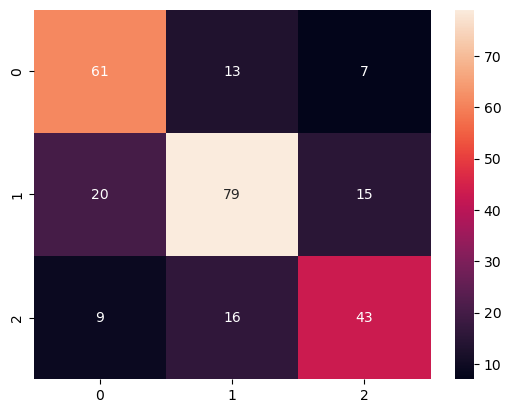

In [156]:
import seaborn as sbn
from sklearn.metrics import confusion_matrix, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
sbn.heatmap(cm, fmt='d', annot=True)

### Handling class imbalance using under sampling and over sampling 

In [158]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [159]:
smt = SMOTE(random_state=42)
X_tomek, y_tomek = smt.fit_resample(X_train_count, y_train)
sm_model = XGBClassifier(n_estimators=170)

sm_model.fit(X_tomek, y_tomek)
y_pred = sm_model.predict(X_test_count)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        81
           1       0.75      0.70      0.72       114
           2       0.66      0.65      0.65        68

    accuracy                           0.70       263
   macro avg       0.70      0.70      0.70       263
weighted avg       0.70      0.70      0.70       263



### RandomizedSearchCV to find best hyperparameters, Hyperparameter tuning

In [161]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {
#     'n_estimators': [100,120,140,150,160],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'subsample': [0.6, 0.8, 1],
#     'colsample_bytree': [0.6, 0.8, 1]
# }

# rs_model = XGBClassifier(random_state=42)
# search = RandomizedSearchCV(rs_model, param_grid, cv=7, n_iter=20, scoring='accuracy')
# search.fit(X_train_count, y_train)

# search.best_params_, search.best_score_

### Trying fine tuning the model with KFold and StratifiedKFold

In [163]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [164]:
# kf = StratifiedKFold(n_splits=22, shuffle=True, random_state=42)

# nb_model = XGBClassifier()
# X_refined_count = count_vec.fit_transform(df.data)
# nb_cv_score = cross_val_score(nb_model, X_refined_count, y, cv=kf, scoring="accuracy")
# print("XGBClassifier Cross-Validation Accuracy: ", nb_cv_score.mean())

# Analysis
- Tried Naive bayes model but accuracy was ranging between 37-51%.
- XGBoost with n_estimators=160, eval_metric='logloss' hyperparameter is giving 71% accuracy.
- Tried undersampling and oversampling techniques but the accuracy still accuracy ranges between 65-68%.
- Tried fine tuning model with KFold and Stratified KFold techniques but still accuracy ranges between 65-78%.

#### Conclusion

We are chossing XGBoost with n_estimators=160, eval_metric='logloss' hyperparameter with 71% accuracy.

In [166]:
data = ['1022.09 Complete Access Engineering Survey UK UK - Default']
data_count = count_vec.transform(data)
xmodel.predict(data_count)


array([2])

In [186]:
from joblib import dump
data = {
    'model': xmodel,
    'count_vec': count_vec
}

dump(data, 'artifacts/model.joblib')

['artifacts/model.joblib']